In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import seaborn as sns
import sklearn.metrics as sk_metrics

import tensorflow.keras.preprocessing as image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


import time
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)


2.4.1


## Téléchargement de données
On utilisera une base de données contenant plusieurs images de fleurs de 5 catégories. On Télécharge et extraire un fichier zip contenant les images à partir de ce lien ** "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"**
, ou soit j'utilise ce lien ** "http://localhost:8888/tree/Desktop/autoformation/Transfer_learning/flower_photos"** depuis mon ordinateur parceque j'ai déja téléchargé le dossier **flowers_photos**


In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', # nom du fichier
                                   untar=True) # décompresser le dossier
data_dir = pathlib.Path(data_dir)

## Télécharger le jeu de données
Le jeu de données Flowers_photos contient 5 sous-répertoires, un par classe:
flowers_photos/daisy/dandelion/roses/sunflowers/tulips/

Chaque répertoire contient des images de ce type de fleur. Voici quelques roses:



In [4]:
Nbre_images = len(list(data_dir.glob('*/*.jpg')))
print(Nbre_images) # On a au total 3670 image de fleurs pour les 5 categories

3670


In [5]:
fleurs=["daisy","dandelion","roses","sunflowers","tulips"] # les 5 catégories de fleurs
fleurs[:3]

['daisy', 'dandelion', 'roses']

nombres de roses est= 641


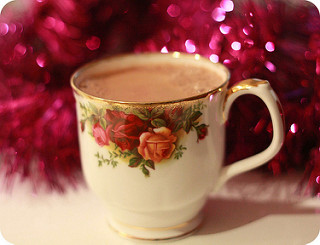

In [6]:
roses = list(data_dir.glob('roses/*'))
print("nombres de roses est=",len(roses))
PIL.Image.open(str(roses[523]))

nombres de tulips est= 799


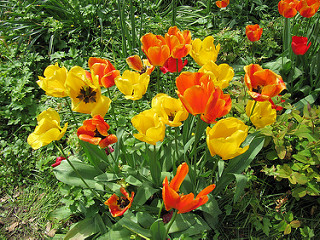

In [7]:
tulips = list(data_dir.glob('tulips/*'))
print("nombres de tulips est=",len(tulips))
PIL.Image.open(str(tulips[120]))

### Charger à l'aide de keras.preprocessing
On crée un **tf.data.Dataset** pour l'apprentissage et la validation à l'aide de **tf.keras.preprocessing.image_dataset_from_directory**
On charge les données avec l'API et on utilise une séparation de validation lors du développement de votre modèle. Nous utiliserons 80% des images pour l'apprentissage et 20% pour la validation

In [8]:
batch_size=32
heigth=180
width=180
channel=3
image_size=(heigth,width)


In [9]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
                                data_dir,
                                color_mode='rgb', 
                                batch_size=batch_size,
                                image_size=image_size, 
                                subset="training",
                                 seed=123, validation_split=0.2)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                    data_dir,
                                    validation_split=0.2,
                                    subset="validation",
                                    seed=123,
                                    image_size=image_size,
                                    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
# On retrouve les nom des classes avec class_names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualisez les données
Voici les 9 premières images de l'ensemble de données d'entraînement.




32


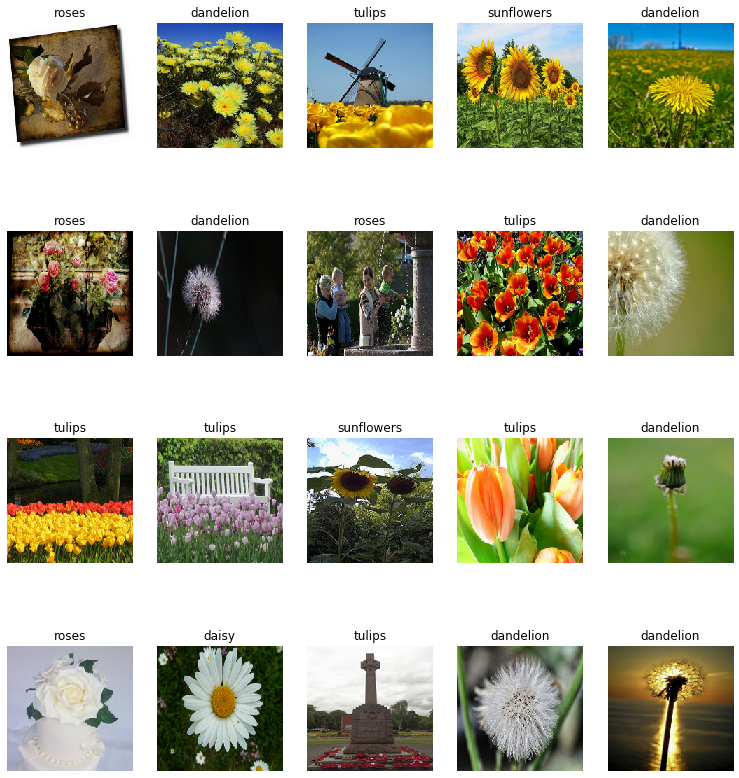

In [12]:
plt.figure(figsize=(13,14))
plt.subplots_adjust(hspace=0.5)
for image,label in train_ds.take(1):
    print(len(label))
    for i in range(20):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [13]:
%%time
for imag_train,labes_train in train_ds:
    print("image shape :"+str(imag_train.shape)+", label shape : "+str(label.shape))
    break


image shape :(32, 180, 180, 3), label shape : (32,)
CPU times: user 1.02 s, sys: 128 ms, total: 1.15 s
Wall time: 2.9 s


La base de données d'origine ne contient que la training set et validation set. Pour créer un  test set. Pour ce faire, on détermine le nombre de lots de données disponibles dans l'ensemble de validation à l'aide de **tf.data.experimental.cardinality** , puis on déplace 20% d'entre eux vers une nouvelle base qui est test set.

### Configurer la base de données pour une meilleur performance
Les GPU et les TPU peuvent réduire considérablement le temps nécessaire pour exécuter une seule étape d'entraînement. Pour atteindre des performances optimales, il faut un pipeline d'entrée efficace qui fournit des données pour l'étape suivante avant la fin de l'étape en cours. L'API tf.data permet de créer des pipelines d'entrée flexibles et efficaces.

La prélecture chevauche le prétraitement et l'exécution du modèle d'une étape d'apprentissage. Pendant que le modèle exécute l'étape d'apprentissage **s** , le pipeline d'entrée lit les données pour l'étape **s+1** . Cela réduit le temps de pas au maximum de formation et le temps nécessaire pour extraire les données.

On utilise la prélecture **tf.data.AUTOTUNE** pour charger des images à partir du disque sans que les E / S deviennent bloquantes. 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)


### Augmentation des données
On dispose au totale 3670 images dans notre jeu de données. Ce jeu de données n'est pas assez volumineux, il est recommandé d'introduire artificiellement une diversité d'échantillons en appliquant des transformations aléatoires, mais réalistes, aux images d'entraînement, telles que la rotation et le retournement horizontal. Cela permet d'exposer le modèle à différents aspects des données d'entraînement et de réduire l'overfitting . 

In [15]:
data_augmentation = Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

#### Remarque:
Ces couches ne sont actives que pendant l'entraînement, lorsqu'on appele **model.fit** . Ils sont inactifs lorsque le modèle est utilisé en mode inférence dans **model.evaulate** ou model.fit .

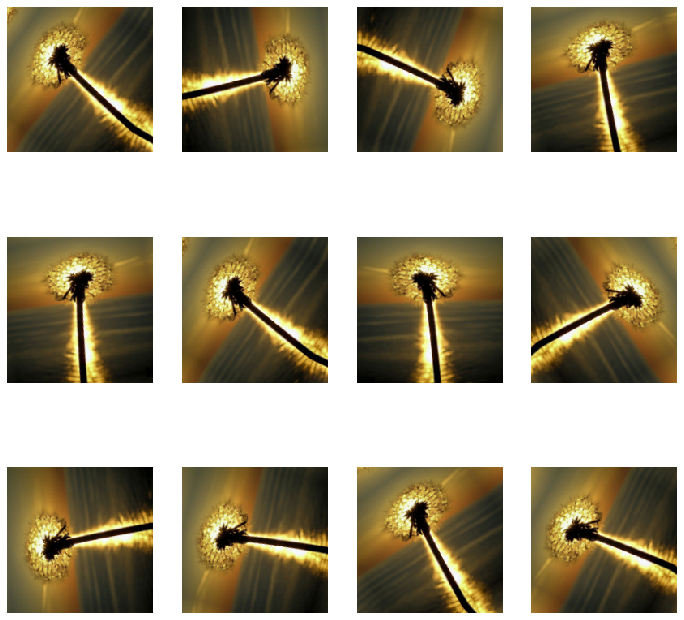

In [20]:
## Exemple
for image, label in train_ds.take(1):
    plt.figure(figsize=(12,12))
    random_image=image[30]
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        augmented_image = data_augmentation(tf.expand_dims(random_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

## Télécharger le classificateur
On utilise **hub.KerasLayer** pour charger le modèle MobileNetV2 à partir de TensorFlow Hub. mais tout modèle de classifieur d'images compatible de tfhub.dev fonctionne



#### Redimensionner les valeurs des pixels
On va télécharger le modèle **tf.keras.applications.MobileNetV2** pour l'utiliser comme modèle de base. Ce modèle attend des valeurs de pixel dans [-1,1] , mais à ce stade, les valeurs de pixel dans vos images sont dans [0-255] . Pour les redimensionner, On utilise la méthode de prétraitement incluse avec le modèle.

##### Remarque: 
Si on utilise d'autres **tf.keras.applications** , assurez-vous de vérifier la documentation de l'API pour déterminer s'ils attendent des pixels dans [-1,1] ou [0,1] , ou on utilise la fonction preprocess_input incluse.





In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## Importer le modèle de base à partir des convnets pré-entraînés
On crée le modèle de base à partir du modèle MobileNetV2 développé par Google.C'est un moddèle entrainé sur la base de données ImageNet, une grande base de données composé de 1,4 million d'images et de 1000 classes. Cette base de connaissances nous aidera à classer les fleurs à partir de notre base de données spécifique.

Avant tout, On doit choisir la couche de MobileNet V2 qu'on utilisera pour l'extraction de des connaissances (features). On instancie le modèle MobileNet V2 préchargé avec des poids entrainés sur ImageNet. On précise l'argument **include_top = False** , vous chargez un réseau qui n'inclut pas la dernière couche de classification du modèle mobilnetv2, ce qui est idéal pour l'extraction des features.



In [22]:
IMG_SHAPE = image_size + (3,) # adapter le shape (180,180) à (180,180,3)
model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Cet extracteur de connaissance convertit chaque image 180x180x3 en un bloc de features 6x6x1280 . Voyons ce qu'il fait à un exemple de lot d'images:

In [23]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [25]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

On a au total $2.25 M$ de parametres parmi les quels $2.22 M$ sont trainables et $34M$ sont non trainables. C'est vraiment important de geler **base_model** avant de compiler et l'apprentissage. Le fait de géler empêche la mise à jour des poids dans une couche donnée pendant l'entraînement car MobileNet V2 comporte de nombreuses couches.

In [26]:
model.trainable=False

In [27]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Ajout d'une couche de classification 

Pour générer des prédictions à partir des bloc d'éléments, on utilise une couche **tf.keras.layers.GlobalAveragePooling2D** pour convertir les éléments en un seul grand vecteur de 1280 éléments par image.

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # couche de la moyenne globale
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [50]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
Classifieur= tf.keras.Model(inputs, outputs)

In [51]:
#on utilisera la perte **categorical_crossentropy** 
#car mes labels cibles sont sous forme de categories et 10 classes

Classifieur.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#Classifieur.compile(loss=tf.keras.losses.categorical_crossentropy,
               #optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])


In [52]:
Classifieur.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

Les 2,26 millions paramètres de MobileNet sont gelés, mais il y a 6,4K paramètres pouvant être entraînés dans la couche dense. Ceux-ci sont répartis entre deux objets tf.Variable , les poids et les biais.

In [53]:
epoch_initial=10
validation_step=20

Loss,Accuracy=Classifieur.evaluate(validation_ds)
print(" Accuracy: {:5.2f}%".format(100*Accuracy))
print(" Loss: {:.2f}".format(Loss))

23/23 [==============================] - 30s 978ms/step - loss: 0.3807 - accuracy: 0.8802
 Accuracy: 88.83%
 Loss: 0.35


On a évalué notre classifieur sur la validation set avant l'apprentissage, il ressort qu'on a une losse élevé et une mauvaise précision de l'odre de $17.4\%$ 

## Entrainement de notre classifieur

In [40]:
%%time
# sauvegarder les paramètres pendant l'entrainement
checkpoint_path = "training "
checkpoint_dir = os.path.dirname(checkpoint_path)

# Création d'un callback qui recharge les paramètres du modèle
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
history = Classifieur.fit(train_ds,
                    epochs=epoch_initial,
                    validation_data=validation_ds,callbacks=[callback])

Epoch 1/10
92/92 [==============================] - 128s 1s/step - loss: 0.9145 - accuracy: 0.6522 - val_loss: 0.5405 - val_accuracy: 0.8038
Epoch 2/10
92/92 [==============================] - 128s 1s/step - loss: 0.5309 - accuracy: 0.8099 - val_loss: 0.4408 - val_accuracy: 0.8460
Epoch 3/10
92/92 [==============================] - 129s 1s/step - loss: 0.4547 - accuracy: 0.8362 - val_loss: 0.4273 - val_accuracy: 0.8501
Epoch 4/10
92/92 [==============================] - 130s 1s/step - loss: 0.3976 - accuracy: 0.8566 - val_loss: 0.3915 - val_accuracy: 0.8624
Epoch 5/10
92/92 [==============================] - 131s 1s/step - loss: 0.3772 - accuracy: 0.8549 - val_loss: 0.3955 - val_accuracy: 0.8706
Epoch 6/10
92/92 [==============================] - 133s 1s/step - loss: 0.3705 - accuracy: 0.8668 - val_loss: 0.3734 - val_accuracy: 0.8706
Epoch 7/10
92/92 [==============================] - 134s 1s/step - loss: 0.3401 - accuracy: 0.8770 - val_loss: 0.3850 - val_accuracy: 0.8733
Epoch 8/10
92

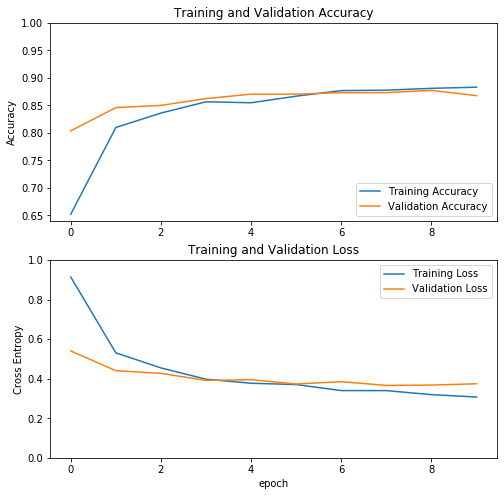

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Degeler les couches du modèle
Cette fois ci on dégele le modèle et de régler les couches inférieures pour qu'elles ne puissent pas être entrainer. Ensuite, on va recompiler le modèle  et reprendre l'entraînement.

In [42]:
model.trainable = True

In [43]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [44]:
len(model.layers) # nombres de couche de notre modèle de base

154

In [42]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
Classifieur= tf.keras.Model(inputs, outputs)

In [43]:
Classifieur.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [45]:
Classifieur.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [46]:
epoch_after=10
epoch_total=epoch_initial+epoch_after


In [47]:
%%time
# sauvegarder les paramètres pendant l'entrainement
checkpoint_path = "training "
checkpoint_dir = os.path.dirname(checkpoint_path)

# Création d'un callback qui recharge les paramètres du modèle
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
history=Classifieur.fit(train_ds,
                  epochs=epoch_total,
                 initial_epoch =  history.epoch[-1],

                  validation_data=validation_ds,callbacks=[callback])

Epoch 10/20
92/92 [==============================] - 124s 1s/step - loss: 0.2928 - accuracy: 0.8869 - val_loss: 0.3633 - val_accuracy: 0.8774
Epoch 11/20
92/92 [==============================] - 132s 1s/step - loss: 0.3056 - accuracy: 0.8873 - val_loss: 0.3574 - val_accuracy: 0.8856
Epoch 12/20
92/92 [==============================] - 152s 2s/step - loss: 0.3028 - accuracy: 0.8886 - val_loss: 0.3567 - val_accuracy: 0.8828
Epoch 13/20
92/92 [==============================] - 169s 2s/step - loss: 0.2825 - accuracy: 0.8961 - val_loss: 0.3645 - val_accuracy: 0.8706
Epoch 14/20
92/92 [==============================] - 139s 1s/step - loss: 0.2905 - accuracy: 0.8944 - val_loss: 0.3590 - val_accuracy: 0.8801
Epoch 15/20
92/92 [==============================] - 128s 1s/step - loss: 0.2966 - accuracy: 0.8917 - val_loss: 0.3674 - val_accuracy: 0.8787
Epoch 16/20
92/92 [==============================] - 129s 1s/step - loss: 0.2741 - accuracy: 0.8985 - val_loss: 0.3614 - val_accuracy: 0.8842
Epoch 

In [48]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

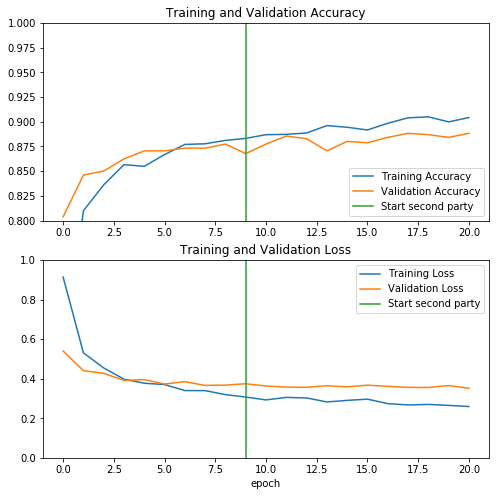

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epoch_initial-1,epoch_initial-1],
          plt.ylim(), label='Start second party')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epoch_initial-1,epoch_initial-1],
         plt.ylim(), label='Start second party')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()